In [1]:
import os
import numpy as np
import numpy.random as rand
from scipy import signal as sig, interpolate as interp, integrate
import matplotlib.pyplot as mp
import cv2 as cv
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn")
mp.rcParams["axes.axisbelow"] = True
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (16/2, 9/2)
mp.rcParams["figure.dpi"] = 100
mp.rcParams["text.latex.preamble"] = [r"\usepackage{physics}"]

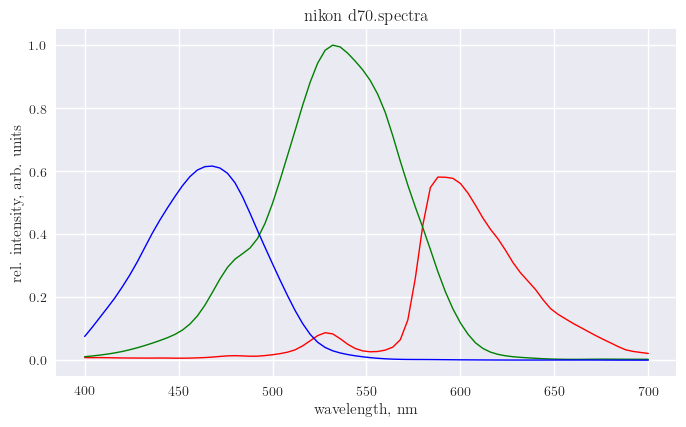

In [3]:
f = 'nikon_d70.spectra'
wl, r, g, b = np.genfromtxt(f).T
mp.plot(wl, r, 'r-', wl, g, 'g-', wl, b, 'b-', lw=1)
mp.title(' '.join(f.split('_')[:2]))
mp.xlabel('wavelength, nm')
mp.ylabel('rel. intensity, arb. units')
mp.savefig('nikond70.png', dpi=300, bbox_inches='tight')
mp.show()

In [8]:
class ColorRender:
    def loadLight(self, filename, savgol=False):
        data = np.genfromtxt(filename, skip_header=4)
        self.M_wavelength, self.M_intensity = data.T
        self.M_intensity /= self.M_intensity.max()
        if savgol:
            self.M_int_orig = self.M_intensity.copy()
            self.M_intensity = sig.savgol_filter(self.M_int_orig, 71, 3)
        
    def loadReflectance(self, filename, savgol=False):
        data = np.genfromtxt(filename, skip_header=4)
        self.R_wavelength, self.R_intensity = data.T
        self.R_intensity /= self.R_intensity.max()
        if savgol:
            self.R_int_orig = self.R_intensity.copy()
            self.R_intensity = sig.savgol_filter(self.R_int_orig, 71, 3)
        
    def loadSensitivity(self, filename):
        data = np.genfromtxt(filename)
        self.S_wavelength, self.S_R, self.S_G, self.S_B = data.T
        
    def equalizeLengths(self):
        overall_wlmin = max(self.M_wavelength.min(), self.R_wavelength.min(), self.S_wavelength.min())
        overall_wlmax = min(self.M_wavelength.max(), self.R_wavelength.max(), self.S_wavelength.max())
        overall_wllen = max(self.M_wavelength.size, self.R_wavelength.size, self.S_wavelength.size)
        
        R_interp = interp.interp1d(self.S_wavelength, self.S_R)
        G_interp = interp.interp1d(self.S_wavelength, self.S_G)
        B_interp = interp.interp1d(self.S_wavelength, self.S_B)
        refl_interp = interp.interp1d(self.R_wavelength, self.R_intensity)
        
        self.wavelength = np.linspace(overall_wlmin, overall_wlmax, overall_wllen)
        self.R_intensity = refl_interp(self.wavelength)
        self.Sr = R_interp(self.wavelength)
        self.Sg = G_interp(self.wavelength)
        self.Sb = B_interp(self.wavelength)
        
    def computeDigiNumber(self):
        self.DN = np.array([integrate.trapz(self.M_intensity * self.R_intensity * Si, 
                                            self.wavelength)
                            for Si in [self.Sr, self.Sg, self.Sb]])
        
    def main(self, kwargs, emit_filter=False, refl_filter=False, save=False, savename=None):
        self.loadLight(kwargs.pop('emittance_filename'))
        self.loadReflectance(kwargs.pop('reflectance_filename'))
        self.loadSensitivity(kwargs.pop('sensitivity_filename'))
        self.equalizeLengths()
        self.computeDigiNumber()
        
        P = np.dstack([np.ones((512, 512))*n for n in self.DN])
        P = (P*255).astype('uint8')
        mp.imshow(P)
        mp.axis('off')
        if save:
            if savename is None:
                cv.imwrite('render.png', P)
            else:
                cv.imwrite(savename, P)
        mp.show()

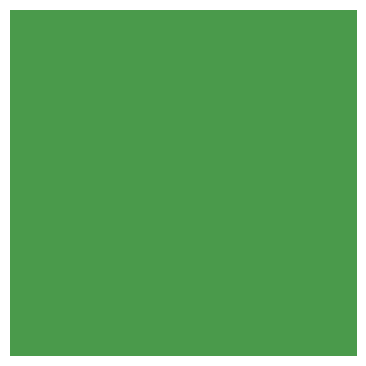

In [9]:
filename_kwargs = dict({'emittance_filename': 'reference_7.txt',
                        'reflectance_filename': 'leaf1_4.txt',
                        'sensitivity_filename': 'nikon_d70.spectra'})
rend = ColorRender()
rend.main(filename_kwargs, False, True, False)